In [15]:
################第一步应该执行这个cell############################
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import astropy_mpl_style
#### 以下代码把drp那个file改掉，把plate改成is_ring，1是有ring，0是没ring
drpall = fits.open('drpall-v2_1_2.fits')
ringflist= pd.read_csv('C:/Users/astro/Desktop/MaNGA/rings_new/ringfilelist.csv',encoding = 'utf-8')
ringfilelist=ringflist.values
for i in range(0,ringfilelist.size):
    ringfilelist[i][0]=ringfilelist[i][0].lstrip('manga-').rstrip('.elines.rgb.png')
ring_mangaid=[];
ring_dec=[];
ring_ra=[];
ringdrpind=[];
ring_ba=[];
for i in range(0,ringfilelist.size):
    ringdrpind.append(np.where(drpall[1].data['PLATEIFU']==ringfilelist[i][0])[0][0])
    ringind=np.where(drpall[1].data['PLATEIFU']==ringfilelist[i][0])[0][0]
    ring_mangaid.append(drpall[1].data['MANGAID'][ringind][0])
    ring_dec.append(drpall[1].data['OBJDEC'][ringind])
    ring_ra.append(drpall[1].data['OBJRA'][ringind])
    ring_ba.append(drpall[1].data['nsa_sersic_ba'][ringind])
    # 当然还可以调用其他值
    ## 此处可以再调用MPA的结果，记录下galaxy的type

## 这里把plate当成is ring来使用 不要介意哈
# 改plate的值
for i in range(0, len(ringdrpind)):
    t=ringdrpind[i]
    drpall[1].data['plate'][t]=1
for i in range(0, drpall[1].data['plate'].size):
    if drpall[1].data['plate'][i]!=1:
        drpall[1].data['plate'][i]=0

In [16]:
ringfilelist.shape

(162, 1)

In [176]:
##################导入所有星系的数据#############################
##################请谨慎执行这个cell############################
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import astropy_mpl_style
flist= pd.read_csv('H:/MaNGA/2.1.2/filelist.csv',encoding = 'utf-8')
filelist=flist.values
#drpall = fits.open('drpall-v2_1_2.fits')
drpdata = drpall[1].data
redshift_set=[];
ID=[];
Lha=[];
Lhb=[];
Lnii=[];
mass=[];
sersic_th50=[];
core_Lnii=[];
core_Lha=[];
core_Lhb=[];
core_EWha=[];
sum_EWha=[];
core_EWnii=[];
for i in range(0,filelist.size):
    cubeset=fits.open('H:/MaNGA/2.1.2/'+filelist[i][0])
    dx=-cubeset[3].header['CD1_1']*3600 ##########一个spaxel是dx=0.5角秒################
    dy=cubeset[3].header['CD2_2']*3600
    x_center = np.int(cubeset[3].header['CRPIX1']) - 1
    y_center = np.int(cubeset[3].header['CRPIX2']) - 1###############中心位置的信息，以spaxel为单位##############
    ID.append(cubeset[0].header['MANGAID'])
    ind=np.where(drpdata['mangaid']==cubeset[0].header['MANGAID'])########ind是该星系在drpall中的位置############
    mass.append(drpdata['nsa_sersic_mass'][ind][0])  # MASS
    redshift=drpdata['nsa_z'][ind][0]
    redshift_set.append(drpdata['nsa_z'][ind][0])
    sersic_th50.append(drpdata['nsa_sersic_th50'][ind][0])
    ha=cubeset[3].data[45].flat#NAME28  = 'flux Hb' NAME45  = 'flux Ha' NAME46  = 'flux NII'
    Lha.append(np.sum(ha))
    hb=cubeset[3].data[28].flat#NAME28  = 'flux Hb' NAME45  = 'flux Ha' NAME46  = 'flux NII'
    Lhb.append(np.sum(hb))
    nii=cubeset[3].data[46].flat
    Lnii.append(np.sum(nii)) ############该星系所有spaxel的NII值之和##############
    sum_EWha.append(cubeset[3].data[216].sum())
    r=0.5*sersic_th50[i]/dx #############定义半径，注意此处的th50是针对r波段的################
    core_nii=core_ha=core_hb=core_ewha=core_ewnii=0
    for i in range(0,cubeset[3].data[46].shape[1]):
        for j in range(0, cubeset[3].data[46].shape[1]):
            if (i-x_center)**2+(j-y_center)**2<r**2:
                core_nii+=cubeset[3].data[46][i][j]
                core_ha+=cubeset[3].data[28][i][j]
                core_hb+=cubeset[3].data[45][i][j]
                core_ewha+=cubeset[3].data[216][i][j]
                core_ewnii+=cubeset[3].data[210][i][j]
    core_Lnii.append(core_nii)
    core_Lha.append(core_ha)
    core_Lhb.append(core_hb)
    core_EWha.append(core_ewha)
    core_EWnii.append(core_ewnii)
    cubeset.close()
    
redshift_set=np.array(redshift_set)
sersic_mass=np.array(mass)
ID=np.array(ID)
Lha=np.array(Lha)
Lhb=np.array(Lhb)
Lnii=np.array(Lnii)
core_Lnii=np.array(core_Lnii)
core_Lha=np.array(core_Lha)
core_Lhb=np.array(core_Lhb)
ring_Lha=Lha-core_Lha
sum_EWha=np.array(sum_EWha)
core_EWha=np.array(core_EWha)
ring_EWha=sum_EWha-core_EWha
core_EWnii=np.array(core_EWnii)

In [20]:
######################################################################
# 导入Pipe3D之后是要测距#
# 测距！！！！！
######################################################################
import sys
from math import *
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
DL_Mpc_set=cosmo.luminosity_distance(redshift_set) 
DL_Mpc_set=np.array(DL_Mpc_set)
SFR=[];
Lha1=[];
Lhb1=[];
for i in range(0, DL_Mpc_set.size):
    Lha1.append(Lha[i]*4*np.pi*(DL_Mpc_set[i]*3.08567758)**2) ## 单位：10^32 erg/s
    Lhb1.append(Lhb[i]*4*np.pi*(DL_Mpc_set[i]*3.08567758)**2)
    if (Lhb1[i]<0):
        SFR.append(Lha1[i]/(1.26*10**9))
    elif Lha1[i]==0:
        SFR.append(0)
    else:
        SFR.append(Lha1[i]*((Lha1[i]/Lhb1[i]/2.8)**2.36)/(1.26*10**9))

log_sersic_mass=np.log10(sersic_mass)
log_SFR=np.log10(SFR);

In [19]:
tryit=fits.open('manga-8341-12704.Pipe3D.cube.fits.gz')


In [48]:
np.mean(tryit[3].data[28].flat)/np.mean(tryit[3].data[256].flat)

16.687429014748982

In [45]:
np.mean(tryit[3].data[256].flat)

0.0032201001936728165

In [18]:
######################打开ring的星系########################
filelist='manga-'+ringfilelist+'.Pipe3D.cube.fits.gz'
#drpall = fits.open('drpall-v2_1_2.fits')
drpdata = drpall[1].data
redshift_set=[];
ring_ra=[];
ring_dec=[];
ID=[];
PLATEID=[];
IFUDSGN=[];
Lha=[];
Lhb=[];
Loiii=[]
Lnii=[];
Lsii=[];
eLha=[];
eLhb=[];
eLoiii=[]
eLnii=[];
eLsii=[];
mass=[];
sersic_th50=[];
core_Lnii=[];
core_Lha=[];
core_Loiii=[];
core_Lsii=[];
core_Lhb=[];
core_EWha=[];
ring_EWha=[];
mean_EWha=[];
sum_EWha=[];
core_EWnii=[];
ring_EWha_mid=[];
for i in range(0,filelist.size):
    cubeset=fits.open('H:/MaNGA/2.1.2/'+filelist[i][0])
    dx=-cubeset[3].header['CD1_1']*3600 ##########一个spaxel是dx=0.5角秒################
    dy=cubeset[3].header['CD2_2']*3600
    x_center = np.int(cubeset[3].header['CRPIX1']) - 1
    y_center = np.int(cubeset[3].header['CRPIX2']) - 1###############中心位置的信息，以spaxel为单位##############
    ID.append(cubeset[0].header['MANGAID'])
    PLATEID.append(cubeset[0].header['PLATEID'])
    IFUDSGN.append(cubeset[0].header['IFUDSGN'])
    ind=np.where(drpdata['mangaid']==cubeset[0].header['MANGAID'])########ind是该星系在drpall中的位置############
    mass.append(drpdata['nsa_sersic_mass'][ind][0])  # MASS
    redshift=drpdata['nsa_z'][ind][0]
    redshift_set.append(drpdata['nsa_z'][ind][0])
    ring_ra.append(drpdata['objra'][ind][0])
    ring_dec.append(drpdata['objdec'][ind][0])
    sersic_th50.append(drpdata['nsa_sersic_th50'][ind][0])
    ha=cubeset[3].data[45].flat#NAME28  = 'flux Hb' NAME45  = 'flux Ha' NAME46  = 'flux NII'    26=OIII
    Lha.append(np.sum(ha))
    hb=cubeset[3].data[28].flat#NAME28  = 'flux Hb' NAME45  = 'flux Ha' NAME46  = 'flux NII'
    Lhb.append(np.sum(hb))
    nii=cubeset[3].data[46].flat
    Lnii.append(np.sum(nii)) ############该星系所有spaxel的NII: 46值之和##############
    oiii=cubeset[3].data[26].flat
    Loiii.append(np.sum(oiii)) ############该星系所有spaxel的OIII:26值之和##############
    sii6717=cubeset[3].data[49].flat
    sii6731=cubeset[3].data[50].flat
    Lsii.append(np.sum(sii6717)+np.sum(sii6731)) ############该星系所有spaxel的SII:49值之和##############
    mean_EWha.append(cubeset[3].data[216].sum()/cubeset[3].data[216].size)
    sum_EWha.append(cubeset[3].data[216].sum())
    r=0.5*sersic_th50[i]/dx #############定义半径，注意此处的th50是针对r波段的################
    core_nii=core_ha=core_hb=core_oiii=core_sii=0
    core_ewha=core_ewnii=ring_ewha=[];
    for i in range(0,cubeset[3].data[216].shape[1]):
        for j in range(0, cubeset[3].data[216].shape[1]):
            if (i-x_center)**2+(j-y_center)**2<r**2:
                core_nii+=cubeset[3].data[46][i][j]
                core_ha+=cubeset[3].data[28][i][j]
                core_hb+=cubeset[3].data[45][i][j]
                core_oiii+=cubeset[3].data[26][i][j]
                core_sii+=cubeset[3].data[49][i][j]
                core_ewha.append(cubeset[3].data[216][i][j])
                core_ewnii.append(cubeset[3].data[210][i][j])
            else:
                ring_ewha.append(cubeset[3].data[216][i][j])
                
    core_ewha_mean=sum(core_ewha)/len(core_ewha)
    core_ewnii_mean=sum(core_ewnii)/len(core_ewnii)
    ring_ewha_mean=sum(ring_ewha)/len(ring_ewha)
    ring_ewha_mid=np.median(np.array(ring_ewha))
    core_Lnii.append(core_nii)
    core_Lha.append(core_ha)
    core_Lhb.append(core_hb)
    core_Loiii.append(core_oiii)
    core_Lsii.append(core_sii)
    core_EWha.append(core_ewha_mean)
    ring_EWha.append(ring_ewha_mean)
    ring_EWha_mid.append(ring_ewha_mid)
    core_EWnii.append(core_ewnii_mean)
    cubeset.close()
    
redshift_set=np.array(redshift_set)
sersic_mass=np.array(mass)
ID=np.array(ID)
Lha=np.array(Lha)
Lhb=np.array(Lhb)
Lnii=np.array(Lnii)
Loiii=np.array(Loiii)
Lsii=np.array(Lsii)
core_Lnii=np.array(core_Lnii)
core_Lha=np.array(core_Lha)
core_Lhb=np.array(core_Lhb)
core_Loiii=np.array(core_Loiii)
core_Lsii=np.array(core_Lsii)
ring_Lha=Lha-core_Lha
mean_EWha=np.array(mean_EWha)
core_EWha=np.array(core_EWha)
ring_EWha=np.array(ring_EWha)
ring_EWha_mid=np.array(ring_EWha_mid)
core_EWnii=np.array(core_EWnii)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


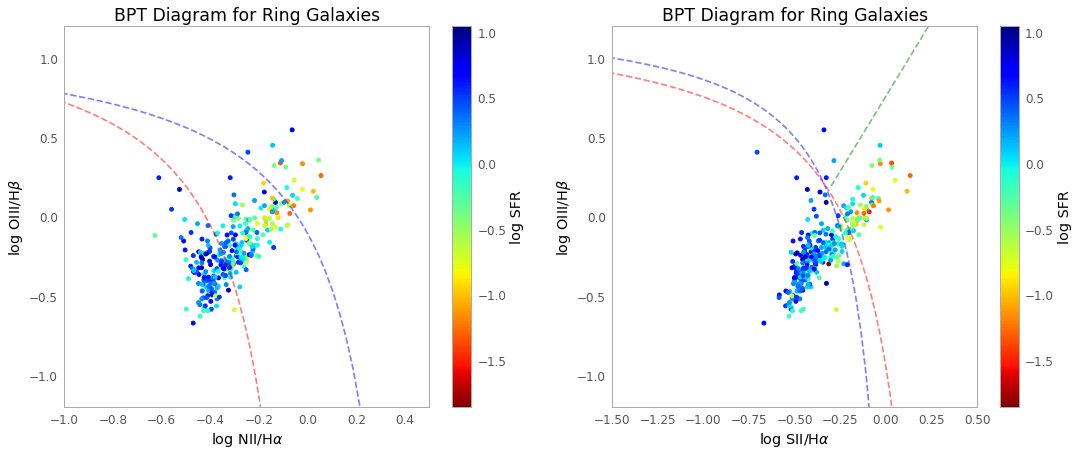

In [39]:
############BPT DIAGRAM FOR RING GALAXIES################
fig=plt.figure(figsize=(18,7))
ax1 = plt.subplot2grid((1,2), (0,0))
plt.scatter(np.log10(Lnii/Lha),np.log10(Loiii/Lhb),c=log_SFR, s=15, marker='o', cmap='jet_r')#np.log10(core_Lnii/ring_Lha)
x=np.linspace(-1.28,0.04,100)
y1=0.61/(x-0.05)+1.30
plt.plot(x,y1,'r--',alpha=0.5)
x=np.linspace(-2.5,0.3,100)
y2=0.61/(x-0.47)+1.19
plt.plot(x,y2,'b--',alpha=0.5)
#plt.gray()
plt.xlim(-1.0,0.5)
plt.ylim(-1.2,1.2)
plt.colorbar(label=r'log SFR')
plt.ylabel(r'$\log$ OIII/H$\beta$')
plt.xlabel(r'$\log$ NII/H$\alpha$')
plt.grid('off')
#plt.ylabel(r'$\log$(EW(NII)$_{core}$/EW(H$\alpha$)$_{core}$)')
plt.title(r'BPT Diagram for Ring Galaxies')

ax2=plt.subplot2grid((1,2),(0,1))
plt.scatter(np.log10(Lsii/Lha),np.log10(Loiii/Lhb),c=log_SFR, s=15, marker='o', cmap='jet_r')#np.log10(core_Lnii/ring_Lha)
x=np.linspace(-0.3,0.5,100)
y1=1.89*x+0.76
plt.plot(x,y1,'g--',alpha=0.5)
x=np.linspace(-2.5,0.1,100)
y2=0.72/(x-0.32)+1.30
y3=0.48/(x-0.10)+1.30
plt.plot(x,y2,'r--',alpha=0.5)
plt.plot(x,y3,'b--',alpha=0.5)
#plt.gray()
plt.xlim(-1.5,0.5)
plt.ylim(-1.2,1.2)
plt.colorbar(label=r'log SFR')
plt.ylabel(r'$\log$ OIII/H$\beta$')
plt.xlabel(r'$\log$ SII/H$\alpha$')
#plt.ylabel(r'$\log$(EW(NII)$_{core}$/EW(H$\alpha$)$_{core}$)')
plt.title(r'BPT Diagram for Ring Galaxies')
plt.grid('off')
#plt.savefig('BPT for ring galaxies.png',dpi=600)
plt.show()

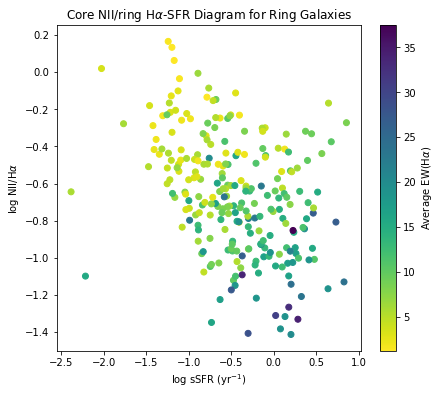

In [31]:
match_fits[1].data['MANGAID']
fig=plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1,2), (0,0))
plt.scatter(match_fits[1].data['SFR_2'],np.log10(match_fits[1].data['core_Lnii']/match_fits[1].data['ring_Lha']), c=-match_fits[1].data['ring_EWha'], marker='o', cmap='viridis_r')#np.log10(core_Lnii/ring_Lha)
#plt.gray()
#plt.xlim(-12,-9)
plt.colorbar(label=r'Average EW(H$\alpha$)')
plt.xlabel('$\log$ sSFR (yr$^{-1}$)')
plt.ylabel(r'$\log$ NII/H$\alpha$')
#plt.ylabel(r'$\log$(EW(NII)$_{core}$/EW(H$\alpha$)$_{core}$)')
plt.title(r'Core NII/ring H$\alpha$-SFR Diagram for Ring Galaxies')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


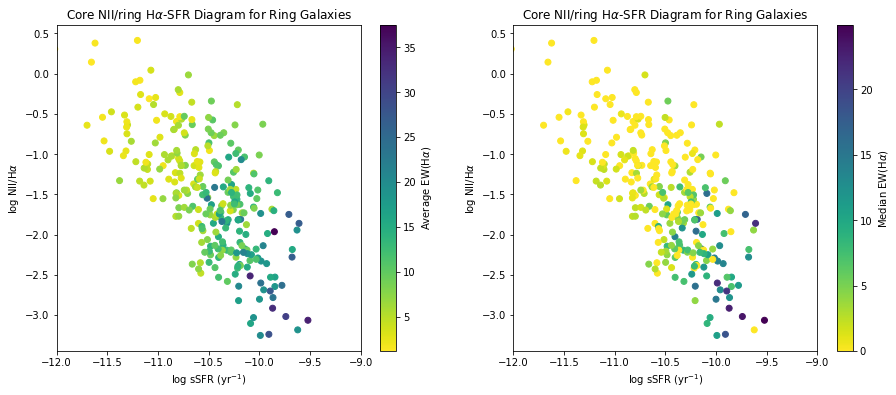

In [7]:
fig=plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1,2), (0,0))
plt.scatter(log_SFR-log_sersic_mass,np.log(core_Lnii/ring_Lha), c=-ring_EWha, marker='o', cmap='viridis_r')#np.log10(core_Lnii/ring_Lha)
#plt.gray()
plt.xlim(-12,-9)
plt.colorbar(label=r'Average EW(H$\alpha$)')
plt.xlabel('$\log$ sSFR (yr$^{-1}$)')
plt.ylabel(r'$\log$ NII/H$\alpha$')
#plt.ylabel(r'$\log$(EW(NII)$_{core}$/EW(H$\alpha$)$_{core}$)')
plt.title(r'Core NII/ring H$\alpha$-SFR Diagram for Ring Galaxies')

ax2=plt.subplot2grid((1,2),(0,1))
plt.scatter(log_SFR-log_sersic_mass,np.log(core_Lnii/ring_Lha), c=-ring_EWha_mid, marker='o', cmap='viridis_r')#np.log10(core_Lnii/ring_Lha)
#plt.gray()
plt.xlim(-12,-9)
plt.colorbar(label=r'Median EW(H$\alpha$)')
plt.xlabel('$\log$ sSFR (yr$^{-1}$)')
plt.ylabel(r'$\log$ NII/H$\alpha$')
#plt.ylabel(r'$\log$(EW(NII)$_{core}$/EW(H$\alpha$)$_{core}$)')
plt.title(r'Core NII/ring H$\alpha$-SFR Diagram for Ring Galaxies')
plt.legend()

plt.savefig('core_NIIring_HA-EW.png',dpi=600)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


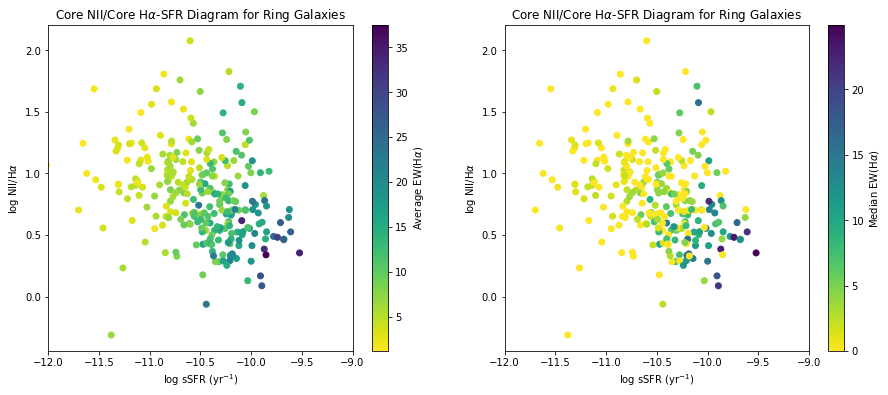

In [8]:
fig=plt.figure(figsize=(15,6))
ax1 = plt.subplot2grid((1,2), (0,0))
plt.scatter(log_SFR-log_sersic_mass,np.log(core_Lnii/core_Lha), c=-ring_EWha, marker='o', cmap='viridis_r')#np.log10(core_Lnii/ring_Lha)
#plt.gray()
plt.xlim(-12,-9)
plt.colorbar(label=r'Average EW(H$\alpha$)')
plt.xlabel('$\log$ sSFR (yr$^{-1}$)')
plt.ylabel(r'$\log$ NII/H$\alpha$')
#plt.ylabel(r'$\log$(EW(NII)$_{core}$/EW(H$\alpha$)$_{core}$)')
plt.title(r'Core NII/Core H$\alpha$-SFR Diagram for Ring Galaxies')

ax2=plt.subplot2grid((1,2),(0,1))
plt.scatter(log_SFR-log_sersic_mass,np.log(core_Lnii/core_Lha), c=-ring_EWha_mid, marker='o', cmap='viridis_r')#np.log10(core_Lnii/ring_Lha)
#plt.gray()
plt.xlim(-12,-9)
plt.colorbar(label=r'Median EW(H$\alpha$)')
plt.xlabel('$\log$ sSFR (yr$^{-1}$)')
plt.ylabel(r'$\log$ NII/H$\alpha$')
#plt.ylabel(r'$\log$(EW(NII)$_{core}$/EW(H$\alpha$)$_{core}$)')
plt.title(r'Core NII/Core H$\alpha$-SFR Diagram for Ring Galaxies')
plt.legend()

plt.savefig('core_NIIcore_HA-EW.png',dpi=600)
plt.show()

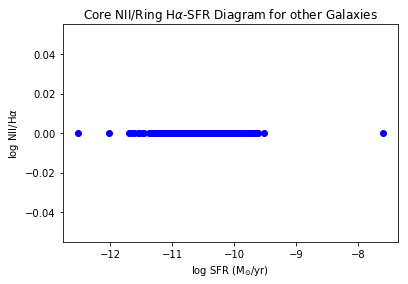

In [181]:
plt.plot(log_SFR-log_sersic_mass,np.log10(core_EWnii/ring_EWha),'bo')#
#plt.xlim(-3.5,1.5)
#plt.ylim(-2,1.2)
plt.xlabel('$\log$ SFR (M$_{\odot}$/yr)')
plt.ylabel(r'$\log$ NII/H$\alpha$')
plt.title(r'Core NII/Ring H$\alpha$-SFR Diagram for other Galaxies')
plt.savefig('core_NIIring_HA.png',dpi=600)
plt.show()

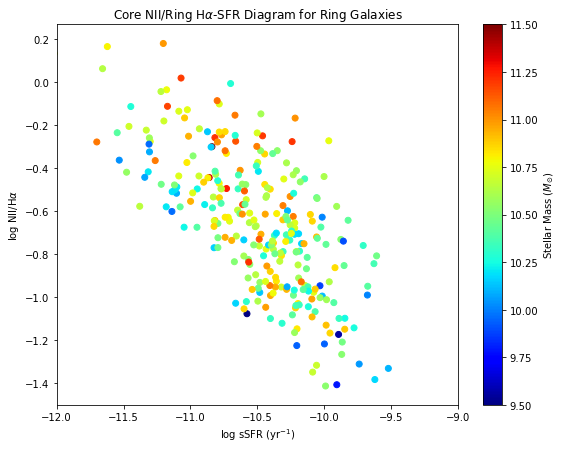

In [194]:
fig=plt.figure(figsize=(9,7))
plt.scatter(log_SFR-log_sersic_mass,np.log10(core_Lnii/ring_Lha), c=log_sersic_mass, marker='o', cmap='jet', vmin=9.5, vmax=11.5)
plt.xlim(-12,-9)
plt.colorbar(label=r'Stellar Mass ($M_{\odot}$)')
#plt.ylim(0.2,1.2)
plt.xlabel('$\log$ sSFR (yr$^{-1}$)')
plt.ylabel(r'$\log$ NII/H$\alpha$')
plt.title(r'Core NII/Ring H$\alpha$-SFR Diagram for Ring Galaxies')
plt.savefig('core_NIIring_HA.png',dpi=600)
plt.show()

In [9]:
ID.shape

(161,)

In [23]:
###############先把这些星系保存到fits文件里头##############################
c1 = fits.Column(name='MANGAID', array=ID, format='20A')
c2 = fits.Column(name='PLATEID', array=PLATEID, format='20A')
c3 = fits.Column(name='IFUDSGN', array=IFUDSGN, format='20A')
c4 = fits.Column(name='objra', array=ring_ra, format='E')
c5 = fits.Column(name='objdec', array=ring_dec, format='E')
c6 = fits.Column(name='redshift', array=redshift_set, format='E')
c7 = fits.Column(name='log_sersic_mass', array=log_sersic_mass, format='E')
c8 = fits.Column(name='log_SFR', array=log_SFR, format='E')
c9 = fits.Column(name='Lha', array=Lha, format='E')
c10 = fits.Column(name='core_Lha', array=core_Lha, format='E')
c11 = fits.Column(name='Lnii', array=Lnii, format='E')
c12 = fits.Column(name='core_Lnii', array=core_Lnii, format='E')
c13 = fits.Column(name='sersic_th50', array=sersic_th50, format='E')
c14 = fits.Column(name='sum_EWha', array=sum_EWha, format='E')
c15 = fits.Column(name='core_EWha', array=core_EWha, format='E')
c16 = fits.Column(name='core_EWnii', array=core_EWnii, format='E')
c17 = fits.Column(name='ring_EWha', array=ring_EWha, format='E')
c18 = fits.Column(name='ring_Lha', array=ring_Lha, format='E')

t = fits.BinTableHDU.from_columns([c1, c2, c3, c4, c5, c6, c7, c8, c9, c10, c11, c12, c13, c14, c15, c16, c17, c18])
t.writeto('2018-02-01-MaNGA-rings-data.fits')

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import astropy_mpl_style

In [3]:
match_fits=fits.open('2018-01-24-match-with-GZ2.fits')
step1=np.logical_and(match_fits[1].data['t01_smooth_or_features_a02_features_or_disk_debiased']>=0.430,match_fits[1].data['t02_edgeon_a05_no_debiased'])
step2=match_fits[1].data['t03_bar_a06_bar_count']>10
step3=np.logical_and(step1,step2)
GZmask=step3
##############导入分批处理的星系的数据####################
process_file_list=['2017-10-27-MaNGA-1-400.fits','2017-10-27-MaNGA-400-1099.fits','2017-10-27-MaNGA-1100-2098.fits','2017-10-27-MaNGA-2099-2810.fits']
tot_MANGAID=[];
tot_redshift=[];
tot_sersic_mass=[];
tot_log_sersic_mass=[];
tot_SFR=[];
tot_log_SFR=[];

for i in range(0,len(process_file_list)):
    process=fits.open(process_file_list[i])
    tot_MANGAID.extend(process[1].data['MANGAID'])# 分别是MANGAID, redshift, sersic_mass, log_sersic_mass, SFR, log_SFR
    tot_redshift.extend(process[1].data['redshift'])
    tot_sersic_mass.extend(process[1].data['sersic_mass'])
    tot_log_sersic_mass.extend(process[1].data['log_sersic_mass'])
    tot_SFR.extend(process[1].data['SFR'])
    tot_log_SFR.extend(process[1].data['log_SFR'])

In [196]:
################导入ring 的SFR等信息###################
ring_MANGAID=[];
ring_redshift=[];
ring_sersic_mass=[];
ring_log_sersic_mass=[];
ring_SFR=[];
ring_log_SFR=[];
ring_data=fits.open('2017-10-30-MaNGA-rings.fits')
ring_MANGAID.extend(ring_data[1].data['MANGAID'])# 分别是MANGAID, redshift, sersic_mass, log_sersic_mass, SFR, log_SFR
ring_redshift.extend(ring_data[1].data['redshift'])
ring_sersic_mass.extend(ring_data[1].data['sersic_mass'])
ring_log_sersic_mass.extend(ring_data[1].data['log_sersic_mass'])
ring_SFR.extend(ring_data[1].data['SFR'])
ring_log_SFR.extend(ring_data[1].data['log_SFR'])

In [197]:
###############筛选ring_face_on的星系###############
face_on_ring_ind=[];
for i in range(0,len(ba)):
    if ba[i]>0.5:
        face_on_ring_ind.append(i)
########一共212个ba>0.5的ring galaxies##########
face_on_ring_log_SFR=[];
face_on_ring_log_sersic_mass=[];
for i in range(0,len(face_on_ring_ind)):
    face_on_ring_log_SFR.append(ring_log_SFR[i])
    face_on_ring_log_sersic_mass.append(ring_log_sersic_mass[i])
########################生成H_face_on_ring的数据，用了直方图2d#########################
bins_for_SFR=np.linspace(-2.5,1.5,25)
bins_for_mass=np.linspace(8,12,25)
H_face_on_ring, bins_for_mass, bins_for_SFR= np.histogram2d(face_on_ring_log_sersic_mass,face_on_ring_log_SFR, bins=(bins_for_mass, bins_for_SFR))
H_face_on_ring=H_face_on_ring.T

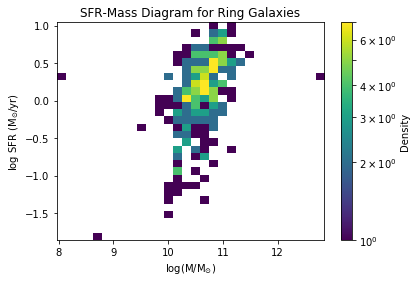

In [198]:
#################画ring的图####################
from matplotlib.colors import LogNorm
from pylab import *
hist2d(ring_log_sersic_mass, ring_log_SFR, bins=30, norm=LogNorm(),cmap='viridis')
colorbar(ticks=None,label='Density')
xlabel('$\log$(M/M$_{\odot}$)')
ylabel('$\log$ SFR (M$_{\odot}$/yr)')
title('SFR-Mass Diagram for Ring Galaxies')
grid('off')
savefig('ring_SFR_mass.png',dpi=600)
show()

In [15]:
len(tot_log_SFR)

2804

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


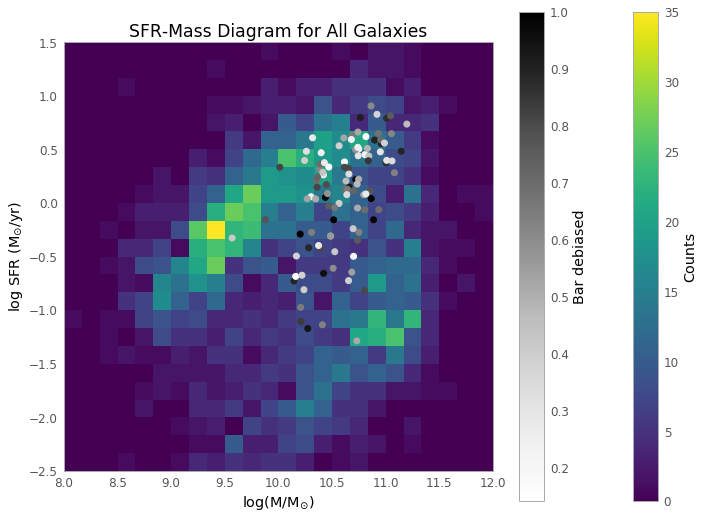

In [5]:
########################所有星系的SFR-MASS图#########################
bins_for_SFR=np.linspace(-2.5,1.5,25)
bins_for_mass=np.linspace(8,12,25)
H, bins_for_mass, bins_for_SFR= np.histogram2d(tot_log_sersic_mass,tot_log_SFR, bins=(bins_for_mass, bins_for_SFR))
H=H.T
fig=plt.figure(figsize=(12,9))
plt.style.use(astropy_mpl_style)
plt.imshow(H, interpolation='nearest',origin='low', cmap='viridis', extent=[bins_for_mass[0],bins_for_mass[-1], bins_for_SFR[0], bins_for_SFR[-1]])
#plt.contour(H,10,extent=[bins_for_mass[0],bins_for_mass[-1], bins_for_SFR[0], bins_for_SFR[-1]], cmap='binary', alpha=0.25)
#plt.imshow(H_ring, interpolation='nearest',origin='low', cmap='hot_r', extent=[bins_for_mass[0],bins_for_mass[-1], bins_for_SFR[0], bins_for_SFR[-1]])
plt.colorbar(label='Counts')

plt.scatter(match_fits[1].data['log_sersic_mass'][GZmask] ,match_fits[1].data['log_SFR'][GZmask],c=match_fits[1].data['t03_bar_a06_bar_debiased'][GZmask], marker='o', cmap='Greys')
plt.colorbar(label='Bar debiased')
plt.xlabel('$\log$(M/M$_{\odot}$)')
plt.ylabel('$\log$ SFR (M$_{\odot}$/yr)')
plt.grid('off')
plt.title('SFR-Mass Diagram for All Galaxies')
#plt.savefig('tot.galaxy.fits')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


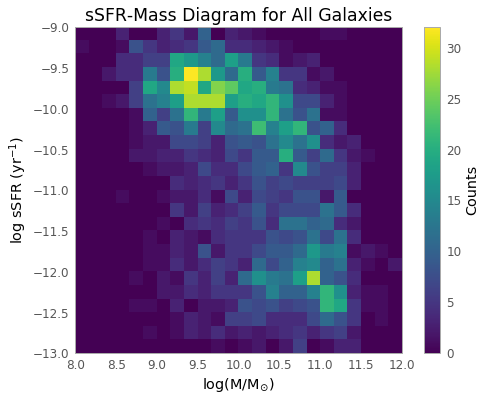

In [214]:
########################所有星系的sSFR-MASS图#########################
bins_for_SFR=np.linspace(-13,-9,25)
bins_for_mass=np.linspace(8,12,25)
tot_sSFR=np.array(tot_SFR)/np.array(tot_sersic_mass)
H, bins_for_mass, bins_for_SFR= np.histogram2d(tot_log_sersic_mass,np.log10(tot_sSFR), bins=(bins_for_mass, bins_for_SFR))
H=H.T
#fig=plt.figure(figsize=(9,9))
plt.style.use(astropy_mpl_style)
plt.imshow(H, interpolation='nearest',origin='low', cmap='viridis', extent=[bins_for_mass[0],bins_for_mass[-1], bins_for_SFR[0], bins_for_SFR[-1]])
#plt.contour(H,10,extent=[bins_for_mass[0],bins_for_mass[-1], bins_for_SFR[0], bins_for_SFR[-1]])
#plt.imshow(H_ring, interpolation='nearest',origin='low', cmap='hot_r', extent=[bins_for_mass[0],bins_for_mass[-1], bins_for_SFR[0], bins_for_SFR[-1]])
plt.colorbar(label='Counts')
#plt.colorbar(label='Counts')
plt.xlabel('$\log$(M/M$_{\odot}$)')
plt.ylabel('$\log$ sSFR (yr$^{-1}$)')
plt.grid('off')
plt.title('sSFR-Mass Diagram for All Galaxies')
plt.savefig('tot_galaxies.png',dpi=600)
plt.show()

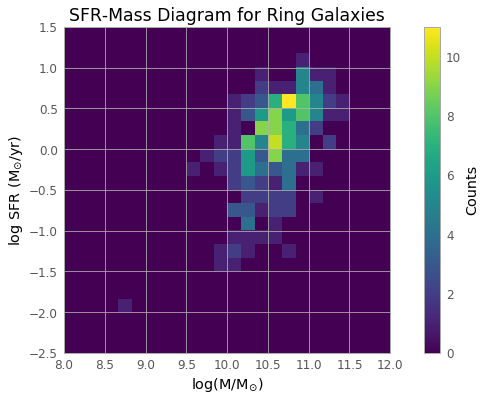

In [207]:
########################画ring的图#########################
bins_for_SFR=np.linspace(-2.5,1.5,25)
bins_for_mass=np.linspace(8,12,25)
H_ring, bins_for_mass, bins_for_SFR= np.histogram2d(ring_log_sersic_mass,ring_log_SFR, bins=(bins_for_mass, bins_for_SFR))
H_ring=H_ring.T
fig=plt.figure(figsize=(12,6))
plt.style.use(astropy_mpl_style)
plt.imshow(H_ring, interpolation='nearest',origin='low', cmap='viridis', extent=[bins_for_mass[0],bins_for_mass[-1], bins_for_SFR[0], bins_for_SFR[-1]])
plt.colorbar(label='Counts')
plt.xlabel('$\log$(M/M$_{\odot}$)')
plt.ylabel('$\log$ SFR (M$_{\odot}$/yr)')
plt.title('SFR-Mass Diagram for Ring Galaxies')
plt.show()

In [35]:
########################画ring的sSFR图#########################
bins_for_SFR=np.linspace(-13,-9,25)
bins_for_mass=np.linspace(8,12,25)
H_ring, bins_for_mass, bins_for_SFR= np.histogram2d(ring_log_sersic_mass,np.array(ring_log_SFR)-np.array(ring_log_sersic_mass), bins=(bins_for_mass, bins_for_SFR))
H_ring=H_ring.T
fig=plt.figure(figsize=(12,6))
plt.style.use(astropy_mpl_style)
plt.imshow(H_ring, interpolation='nearest',origin='low', cmap='viridis', extent=[bins_for_mass[0],bins_for_mass[-1], bins_for_SFR[0], bins_for_SFR[-1]])
plt.xlabel(r'$\log$(M/M$_{\odot}$)')
plt.ylabel('$\log$ sSFR (yr$^{-1}$)')
plt.title('sSFR-Mass Diagram for Ring Galaxies')
plt.savefig('tot_galaxy.fits')
plt.show()

SyntaxError: invalid syntax (<ipython-input-35-6aa70ed91e72>, line 9)

In [33]:
H_ratio=H_ring/H
H_face_on_ratio=H_face_on_ring/H

plt.style.use(astropy_mpl_style)
fig=plt.figure(figsize=(20,8))

ax1 = plt.subplot2grid((1,2), (0,0))
plt.contour(H,10,cmap='viridis',extent=[bins_for_mass[0],bins_for_mass[-1], bins_for_SFR[0], bins_for_SFR[-1]], label='Galaxies from sample')
plt.imshow(H_face_on_ratio,interpolation='bilinear', origin='low', cmap='hot_r', extent=[bins_for_mass[0],bins_for_mass[-1], bins_for_SFR[0], bins_for_SFR[-1]])
plt.colorbar(label='Ratio')
plt.xlabel('$\log$(M/M$_{\odot}$)')
plt.ylabel('$\log$ SFR (M$_{\odot}$/yr)')
plt.title('SFR-Mass Diagram for Face On Ring Galaxies')
plt.grid('on')

ax2 = plt.subplot2grid((1,2), (0,1))
plt.contour(H,10,cmap='viridis',extent=[bins_for_mass[0],bins_for_mass[-1], bins_for_SFR[0], bins_for_SFR[-1]], label='Galaxies from sample')
plt.imshow(H_ratio, interpolation='bilinear',origin='low', cmap='hot_r', extent=[bins_for_mass[0],bins_for_mass[-1], bins_for_SFR[0], bins_for_SFR[-1]])
plt.colorbar(label='Ratio')
plt.xlabel('$\log$(M/M$_{\odot}$)')
plt.ylabel('$\log$ SFR (M$_{\odot}$/yr)')
plt.title('SFR-Mass Diagram for Ring Galaxies')
plt.grid('on')

plt.savefig('SFR-MASS face on ring ratio.png', dpi=600)
plt.show()

NameError: name 'H_ring' is not defined

In [108]:
drpall[1].data['nsa_sersic_n'][drpall[1].data['nsa_sersic_n'][drpall[1].data['nsa_sersic_n']<1.5]>0.5].shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4824 but corresponding boolean dimension is 2857
  """Entry point for launching an IPython kernel.


(796,)

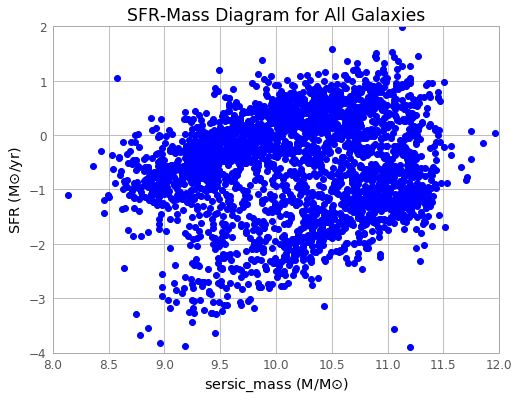

In [260]:
#####################所有星系的SFR-MASS##########################
fig=plt.figure(figsize=(8,6))
plt.plot(tot_log_sersic_mass, tot_log_SFR, 'bo')
plt.plot(tot_SFR,tot_log_sersic_mass)
plt.ylim(-4,2)
plt.xlim(8,12)
plt.xlabel('sersic_mass (M/M$\odot$)')
plt.ylabel('SFR (M$\odot$/yr)')
plt.title('SFR-Mass Diagram for All Galaxies')
plt.show()
#plt.savefig('sfr-mass.png',dpi=600)